Chemical environment transformation tool

In [1]:
import pandas as pd
import numpy as np

'''
Last Updated: 2024-03-19

This code performs statereactions on labelled db files. it mimics leaving group and attaching group by 
removing labelled atoms (leaving group) and building a functional group in its place or somewhere else,

Each atom in the db file must be labelled with sufficient atomic environment depth for this to work
The autolabel code CAN LABEL each atom environment structure up to a specified depth and the resulting 
label file saved to a directory that should be remembered so that it can be specified below.

INPUTS

        RXN_CENTERS       - a dictionary of preset rxn centers that can be accessed with key rxn names (ex. 'pr_alcohol_H2oxidation')
                            You can add rxn centers to the dictionary, rxn centers for a reaction are defined by local structure
                            based on how the autolabel code labels atomic environments.
                            A reaction center follows the following format

                            reaction_atomcenter-<neighbor1-neighbor2-...neighborN>-&-neighbor1_root-<neighbor1's_neighbor1,neighbor1's_negihbor2,...>...
                            
                            specified UP to however many neighbor depths needed to specify reaction center.
                            NOTE once a neighbor becomes a center root at the next depth, it can 
                            never be a center root again, that way the label never goes back in the chain! (it can be a neighbor again though)
                            NOTE neighbors are organized by atomic number priority, and so are branches of neighbors 
                            (if there are multiple branches, which happens at later depths because of having multiple initial neighbors, 
                            the branch where the sum of the atoms (INCLUDING ROOT) add up to the highest priority always comes first, 
                            to avoid problems when you have equal root atoms but not equal branches and how to order them, however if the root atom
                            is high priority that always takes place first! 
                            
                            Example:
                            primary alcohol --> 'C-<O-C-H-H>-&-O-<C-H>-C-'

                                reaction_atom - the atom center (element) at which the reaction will take place (C in above example)
                                <>            - defines a branch of neighbors next an atomic center
                                neighbor1     - the atom's highest priority neighbor (O in above example)
                                neighbor2     - the atom's second highest priority neighbor (C in above example)
                                neighbor3     - ...
                                -&-           - defines the beginning of the next depth of the structure label
                                neighbor1_
                                root          - now the neighbor is the root atom and we define a branch of neighbors for it,
                                                listing them according to atomic number priority (O in the above example)
                                neighbor1's
                                neighbor1     - neighbor1's highest priority neighbor (C in the above example)
                                neighbor1's
                                neighbor2     - neighbor1's second highest priority neighbor (H in the above example)
                                ...
                                keep going up to however many depths required to specify appropriate reaction center environment for reaction

                            There can be multiple reaction centers (ex. diels-alder), so they are placed in a list:
                            
                                'dieneophile': ['C-<[A-Z]-C-H>-&[A-Z-<>]*-C-<C-C-C>-[A-Z-<>]*&-','C-<C-C-C>-&-']            }

                            NOTE that if there is more than one reaction center it is important to ensure that one center references the other to ensure
                            they are part one overall center (i.e ensuring that they are NOT in completely separate regions across the molecule)
                            NOTE the algorithm can handle regular expressions, so you can leave some atoms to be undefined as shown
                            with the square brackets [], to open up possibilities for more reaction sites
                            NOTE also that the algorithm looks for matches from the very beginning of the structure label and never from the middle
                            you never have to worry about an erroneous match of structure label somewhere in the middle of the label! 
                            You also do not have to worry about specifying the entire depth of the structure available! ONLY the parts relevant for the reaction site
        LEAVING_GROUP
        _ATOMS            - A dictionary of preset leaving groups that can be accessed with key leaving group names (ex. 'amide_NH2')   
                            you can add leaving groups to the dictionary and they are defined exactly the same way as above for the reaction centers structure label
                            each atom in the leaving group must have its structure label defined.
                            leaving group atoms additionally come with an integer specifying how many of that atom needs to be removed

                            ex. 'amide_NH2': [['H-<N>-&-N-<C-H-H>-&-C-<O-N-C>-H-<N>-&-',2],['N-<C-H-H>-&-C-<O-N-C>-H-<N>-H-<N>-&-',1]]

                            a label that specifies the removal of NH2, 
                            2 is to allow the algorithm to remove both H's 

                            (sometimes you want to remove just one depending on reaction, ex. methylation, deprotonation)
                            NOTE it is important that each atom'sstructure label includes the reaction site so that we ensure leaving groups
                            come off of the reaction site and nowhere else from the molecule, unless you want to deliberately try that
        ATTACH_GROUP_
        ATOMS             - A dictionary of preset incoming functional groups that can be accessed with key functional group names ('OH','CH3')
                            there are three components to the incoming FG list: 

                            1) mol file xyz lines  (place all elements at 0,0,0 is fine for now)                                          these give the mol file lines that are to be added as the functional group attaches to the reaction site after leaving group is removed
                                the mol file lines always follow the same format, but the element changes in each line,
                                all atoms are placed at first coordinates 0,0,0 but then the force field optimization places them in the right place
                                depending on their bond connectivity
                            2) mol file bond connectivity lines, see below
                            3) additional atoms/bond introduced by this FG in a list, [#additional_atoms, #additional_bonds], do not account fro leaving group that has already been accounted for  

                            ex.   
                            'OH'   : [
                                        '    0.0000    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n',
                                        ' a u  1  0\n b a  1  0\n',
                                        [2,2]
                                        ],

                            the mol file bonding template, is the second object to specify 
                            defines how the functional group attaches to the molecule (and within itself)
                            Since the functional group will always be attached at the END of molecule in mol file
                            the bonding template must follow the following key
                                'a' - number_atoms + 1
                                'b' - number_atoms + 2
                                'c' - number_atoms + 3
                                'd' - number_atoms + 4
                                'e' ... etc
                                'u' - bond_index1 (found through the algorithm looking for reaction center labels)   
                                'v' - bond_index2 (found thorugh the algorithm looking for reaction center labels) 
                                'w' - bond_index3... etc (up to 'z' allowed)
                            thus having 'a' means that the attaching atom is the first one in the functional,
                            'b' is the second one, and so on... 'u,v,w,x,y,z' is reserved for the bond_index which will be found using reaction center labels
                            NOTE that the bonding of the resulting functional group should resemble how it would look in the product molecule
                            NOT the reactant molecule, so for diels-alder the double bond takes place in the middle of the two sides of the diene in the product, 
                            that is what must be specified as the final bonding result, NOT the diene exactly but what happens to the diene-part as a result of the reaction
        REMOVE_BOND_FROM_
        RXNCENTER          - dictionary of structure labels that specify which atom--centers to remove a double bond from, accessed with key reaction center names (ex. "dieneophile")
                             for certain rxns this is required (ex. diels-alder)
                             (usually these are atom label structures near the reaction center structure or exactly the reaction center structure)
                             FOLLOWS THE SAME FORMAT as the REACTION CENTER structure labels, see above
                             ONLY here they are specifying which centers to remove a double bond between
        ADD_BOND_TO_
        RXNCENTER          - dictionary of structure labels that specify which atomic-centers to add a double bond to, accessed with key reaction center names (ex "amide")
                             for certain rxns this is required (ex. oxidation)
                             (usually these are atomic center structures near the reaction center structure or exactly the reaction center structure)
                             FOLLOWS THE SAME FORMAT as the REACTION CENTER structure labels, see above
                             ONLY here they are specifying which centers to add a double bond between
'''


RXN_CENTERS = {
                'pr_alcohol': [['C-<O-C-H-H>-&-O-<C-H>-',1]],
                'strchain_alcohol2': [['C-<O-C-H-H>-&-O-<C-H>[HCNOF<>-]*&-H-<O>-C-<C-C-H-H>[HCNOF<>-]*',1]],
                'strchain_alcohol3':[['C-<O-C-H-H>-&-O-<C-H>-C-<C-C-H-H>-H-<C>-H-<C>-&-H-<O>-C-<C-C-H-H>-H-<C>-H-<C>-',1],['C-<C-C-H-H>-&-C-<O-C-H-H>-C-<C-C-H-H>-H-<C>-H-<C>',1]],
                'asym_alkane': [['C-<C-C-H-H>-&-[HCNOF<>-]*-C-<C-C-C-H>-[HCNOF<>-]*',1]],
                'pr_amide': [['C-<O-N-C>-&-O-<C>-N-<C-H-H>-C[HCNOF<>-]*',1]],
                'pr_amide_hydrointer': [['C-<O-O-N-C>-&-O-<C-H>-O-<C-H>-N-<C-H-H>[HCNOF<>-]*',1]],
                'dieneophile_ewg': [['C-<C-C-H>-&-C-<O-[HCOF]+-[HCOF]+>-C-<C-C-H>[HCNOF<>-]*&-',1],['C-<C-C-H>-&-C-<[HCNOF]+-[HCNOF]+-[HCNOF]+-[HCNOF]+>-C-<C-C-H>[HCNOF<>-]*&-',1]],
                'sym_alkene': [['C-<C-C-H>-&-C-<C-C-H-H>-C-<C-C-H>[HCNOF<>-]*',2]], 
                'sym_alkane': [['C-<C-C-H-H>-&-C-<C-C-H-H>-C-<C-C-H-H>-H-<C>-H-<C>-',2]],
                'CH3CH2': [['C-<C-H-H-H>-&-C-<C-C-H-H>-',1]],
                'OHCH2': [['O-<C-H>-&-C-<O-C-H-H>-H-<O>',1]],
                }

LEAVING_GROUP_ATOMS = {
                        'none': None,
                        'pr_alcohol_H2ox': [['H-<O>-&-O-<C-H>-&-C-<O-C-H-H>-&-',1],['H-<C>-&-C-<O-C-H-H>-&-',1]],
                        'strchain_alcohol2_H2ox': [['H-<O>-&-O-<C-H>-&-C-<O-C-H-H>-&-C-<C-C-H-H>[HCNOF<>-]*',1],['H-<C>-&-C-<O-C-H-H>-&-O-<C-H>-C-<C-C-H-H>',1]],
                        'strchain_alcohol3_H2ox': [['H-<O>-&-O-<C-H>-&-C-<O-C-H-H>-&-C-<C-C-H-H>-H-<C>-H-<C>-&-C-<C-C-H-H>-H-<C>-H-<C>-&-',1],['H-<C>-&-C-<O-C-H-H>-&-O-<C-H>-C-<C-C-H-H>-H-<C>-&-H-<O>-C-<C-C-H-H>-H-<C>-H-<C>',1]],
                        'asym_alkane_H2ox': [['H-<C>-&-C-<C-C-H-H>-&-[HCNOF<>-]*-C-<C-C-C-H>-[HCNOF<>-]*',1],['H-<C>-&-C-<C-C-C-H>-&-[HCNOF<>-]*-C-<C-C-H-H>-[HCNOF<>-]*',1]],
                        'pr_amide_hydro_nointer': [['H-<N>-&-N-<C-H-H>-&-C-<O-N-C>-H-<N>-&-',2],['N-<C-H-H>-&-C-<O-N-C>-H-<N>-H-<N>-&-',1]],
                        'pr_alcohol_H': [['H-<O>-&-O-<C-H>-&-C-<O-C-H-H>-&-',1]],
                        'pr_amide_hydro_step2': [['H-<N>-&-N-<C-H-H>-&-C-<O-O-N-C>-H-<N>-',2],['N-<C-H-H>-&-C-<O-O-N-C>-H-<N>-H-<N>-',1]],
                        'sym_alkene_H2ox': [['H-<C>-&-C-<C-C-H>-&[HCNOF<>-]*C-<C-C-H>[HCNOF<>-]*',2]],
                        'sym_alkane_H2ox': [['H-<C>-&-C-<C-C-H-H>-&-C-<C-C-H-H>-C-<C-C-H-H>-H-<C>',4]],
                        'CH3CH2_methylate': [['H-<C>-&-C-<C-H-H-H>-&-C-<C-C-H-H>',1]],
                        'OHCH2_methylate': [['H-<O>-&-O-<C-H>-&C-<O-C-H-H>-H-<O>-',1]],
                    }  


ATTACH_GROUPS_ATOMS = {
                'none' : [
                          '',
                          '',
                         [0,0],
                        ],      
                'OH'   : [
                          '    0.0000    0.0000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n',
                          ' a z  1  0\n b a  1  0\n',
                          [2,2]
                          ],
                'CH3'  : [
                          '    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n',
                          ' a z  1  0\n b a  1  0\n c a  1  0\n d a  1  0\n',
                          [4,4]
                          ],
                'diene': [
                          '    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n    0.0000    0.0000    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0\n',
                          ' a y  1  0\n b z  1  0\n a c  1  0\n b d  1  0\n c d  2  0\n e a  1  0\n f a  1  0\n g b  1  0\n h b  1  0\n i c  1  0\n j d  1  0\n',
                          [10,11],
                         ]
            }

#Certain reactions require removal of a double bond to a single bond
#For example making the tetrahedral intermediate in nucleophilic acyl substitutions
#This has to be specified at the mol level because adding groups requires optimization! 
#another example is when diene attacks, the main group (dienophile) has to lose a bond
REMOVE_BOND_FROM_RXNSITE = {
                            'none':None,
                            'pr_amide_O=C':[['O-<C>-&-C-<O-N-C>-&-N-<C-H-H>-C[HCNOF<>-]*',1],['C-<O-N-C>-&-O-<C>-N-<C-H-H>-C[HCNOF<>-]*',1]],
                            'dieneophile_ewg':[['C-<C-C-H>-&-C-<O-[HCOF]+-[HCOF]+>-C-<C-C-H>-[HCNOF<>-]*-&-',1],['C-<C-C-H>-&-C-<[HCNOF]+-[HCNOF]+-[HCNOF]+-[HCNOF]+>-C-<C-C-H>-[HCNOF<>-]*-&-',1]]                        }

#Most of the time, double bonds are added for you, on the main structure, in the optimization process if not specified,
#So for instance, if some group left the main structure, which is done on the xyz level (i.e we don't care about bonds)
#a double bond often needs to form in its place, this is automatic when you convert to the mol file of the molecule
#BUT sometimes, you may need to specify to add a double bond, in case the mol file conversion process failed to pick up double bond
#This happens for some reason to C-C bonds, but not for C-O bonds...
#
ADD_BOND_TO_RXNSITE = {
                        'none':None, 
                        'asym_alkane':[['C-<C-C-H-H>-&-[HCNOF<>-]*-C-<C-C-C-H>-[HCNOF<>-]*',1],['C-<C-C-C-H>-&-[HCNOF<>-]*-C-<C-C-H-H>-[HCNOF<>-]*',1]],  
                        'sym_alkene':[['C-<C-C-H>-&[HCNOF<>-]*-C-<C-C-H>-[HCNOF<>-]*',2]],
                        'sym_alkane':[['C-<C-C-H-H>-&-C-<C-C-H-H>-C-<C-C-H-H>-H-<C>-H-<C>-',2]],
                        'pr_alcohol': [['C-<O-C-H-H>-&-O-<C-H>-',1], ['O-<C-H>-&-C-<O-C-H-H>-H-<O>-',1]],
                        'strchain_alcohol2': [['C-<O-C-H-H>-&-O-<C-H>[HCNOH<>-]*&-H-<O>-C-<C-C-H-H>[HCNOF<>-]*',1], ['O-<C-H>-&-C-<O-C-H-H>-H-<O>-&-C-<C-C-H-H>-',1]],
                        'strchain_alcohol3': [['C-<O-C-H-H>-&-O-<C-H>-C-<C-C-H-H>-H-<C>-H-<C>-&-H-<O>-C-<C-C-H-H>-H-<C>-H-<C>-',1],['C-<C-C-H-H>-&-C-<O-C-H-H>-C-<C-C-H-H>-H-<C>-H-<C>-',1]],
                 }
                 
                 
rxn_centers = RXN_CENTERS['pr_amide_hydrointer']
leaving_atoms = LEAVING_GROUP_ATOMS['pr_amide_hydro_step2']
attach_group = ATTACH_GROUPS_ATOMS['none'][0]
attach_group_bonds = ATTACH_GROUPS_ATOMS['none'][1]
attach_group_numb_atomsbonds = ATTACH_GROUPS_ATOMS['none'][2]
remove_bond_from_rxnsite = REMOVE_BOND_FROM_RXNSITE['none']
add_bond_to_rxnsite = ADD_BOND_TO_RXNSITE['none']


SAVE_FILEDIR = 'data/fgtransform/model1/temp/'


#This is purely for visualization 
COLORS_TO_KEEP = {'pr_alcohol_H2ox': ['#AFEEEE', '#1E90FF'],
                  'asym_alkane_H2ox': ['#9ACD32','#008000'],
                  'sym_alkane_H2ox': ['#9ACD32','#008000'],
                  'pr_amide_nointer_hydro_step1': ['#FFD700','#1E90FF'],
                  'pr_amide_nointer_hydro_step2':['#1E90FF','#66CDAA'],
                  'pr_amide_hydro':['#FFD700','#66CDAA'],
                  'dieneophile_ewg': ['#008000','#98FB98'],
                  'sym_alkene_H2ox': ['#008000','#808000'],}

#These molecules fail to geometry optimize the product through RDKit's MMFF94 
SKIP_MOLECULES = {'none': [],
                  'sym_alkane_H2ox': [2032,2635,2636,2649,2664,6562,6563,6587,6588],
                  'asym_alkane_H2ox': [159,468,469,472,670,676,677,680,698,699,700,704,708,1852,1853,1854,1855,1857,1860,1864,1866,1984,2182,2185,2192,2362,2370,2374,2377],
                  'pr_amide_hydro_step1': [8125,9968],
                  }

skip_molecules = SKIP_MOLECULES['none']
colors_to_keep = 'pr_amide_hydro'

SKIP_SYMMETRIC_ATOMS = False


In [2]:

from runrxns import statereaction
import pandas as pd
import numpy as np

'''
Choose a proper transformation/reaction using the dictionaries above and then adjust configuraiton
here to get reactants, removed, products files 

    ARGS:
        rxn_centers          - choosing reaction centers from dictionary of reaction sites (or define own)
        leaving_atoms        - choosing leaving groups atoms from dictionary of leaving groups (or define own)
        attach_group         - choosing fg to attach from dictionary of fg to build
        attach_group_bonds   - choosing the corresponding fg bond to build 
        attach_group_numb
        _atomsbonds          - the corresponding additional number of atoms/bonds due to the attaching group
        remove_bonds_from_
        rxnsite              - choosing to remove a double bond from reaction site if required
        add_bonds_to_
        rxnsite              - choosing to add double bond to reaction site if required
        DATASET_FILEPATH     - the db file that has been labelled with autolabel
        QM9_BOOL             - a boolean depENDing on whether QM9.db is being used because we
                               load all the properties using QM9 method instead
                               of AtomsData for any other db dataset (more efficient)
        LABELS_FILEPATH      - specify the filepath that holds the atomic center structure labels at a sufficient depth
                               for the reaction center (usually a depth of 5 is sufficient for most reaction centers) 
        DEPTH                - depth of structure label in label filepath specified
        MOLECULES_RANGE      - range of molecules to scan for reactions
        REACT_FILEPATH       - filepath that will contain reactants 
        REMOVELG_FILEPATH    - filepath that will contain reactants without LG (without optimization)
        PROD_FILEPATH        - filepath that will contain products with MMFF94 optimization 
        AVAILABLE_PROPERTIES - making the db requires setting an available property even if property is missing
                               this can be anything as filler, long as you remember what the filler database property name is so that it can be accessed
 
    RETURNS:
        statereaction        - initializing the fgtransform class that removes specified LG and adds specified FG
        statereaction2.
        RemoveBuild_LGFG_
        SingleBuildSite      - takes in all the initial parameters of the reaction (control), and initializes the build parameters (build)
        state_reaction.
        RemoveBuild_LGFG     - scans the db file for possible reactants that have LG, performs reactions
                               and writes reactions in the init, rem and out filepath
        number_trans         - number of molecule transformed in the removal
        build_indices_list   - a list of build_indices is returned, 1 per molecule, 
                               helps embedding extraction (next) to extract target build site
        initbuild_indices
        _list                - a list of build_indices before the removal of FG is returned (to avoid the likely mismatch)
                               helps embedding extraction tool (next) to extract target build site before LG was removed
''' 


#Dataset
DATASET_FILEPATH = 'data/fgtransform/model1/pr_amide_hydro_step1/prodlabels/prod.db'
QM9_BOOL=False 

#
LABELS_FILEPATH = 'data/fgtransform/model1/pr_amide_hydro_step1/prodlabels/prodlabels.csv'
DEPTH = 5

MOLECULES_RANGE = [0,127]

#OUTPUT
REACT_FILEPATH = SAVE_FILEDIR + 'react.xyz'
REMOVELG_FILEPATH = SAVE_FILEDIR + 'del.xyz'
PROD_FILEPATH = SAVE_FILEDIR  + 'prod.xyz'

AVAILABLE_PROPERTIES = ['energy']

SKIP = skip_molecules


statereaction = statereaction.RemoveBuild_LGFG_SingleBuildSite(DATASET_FILEPATH,LABELS_FILEPATH,DEPTH,rxn_centers,leaving_atoms,attach_group,attach_group_bonds,attach_group_numb_atomsbonds,add_bond_to_rxnsite,remove_bond_from_rxnsite,MOLECULES_RANGE,AVAILABLE_PROPERTIES,QM9_BOOL,REACT_FILEPATH,REMOVELG_FILEPATH,PROD_FILEPATH,SKIP,SKIP_SYMMETRIC_ATOMS)
number_trans, initbuild_indices_list, build_indices_list  = statereaction.RemoveBuild_LGFG()

print(number_trans)
print(initbuild_indices_list)
print(build_indices_list)

np.savetxt(SAVE_FILEDIR+'build_indices_list.csv',build_indices_list,delimiter=',')
np.savetxt(SAVE_FILEDIR+'initbuild_indices_list.csv',initbuild_indices_list,delimiter=',')

c:\Users\aelsamma\Anaconda3\envs\dlchem6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


reactant found: 0
reactant found: 1
reactant found: 2
reactant found: 3
reactant found: 4
reactant found: 5
reactant found: 6
reactant found: 7
reactant found: 8
reactant found: 9
reactant found: 10
reactant found: 11
reactant found: 12
reactant found: 13
reactant found: 14
reactant found: 15
reactant found: 16
reactant found: 17
reactant found: 18
reactant found: 19
reactant found: 20
reactant found: 21
reactant found: 22
reactant found: 23
reactant found: 24
reactant found: 25
reactant found: 26
reactant found: 27
reactant found: 28
reactant found: 29
reactant found: 30
reactant found: 31
reactant found: 32
reactant found: 33
reactant found: 34
reactant found: 35
reactant found: 36
reactant found: 37
reactant found: 38
reactant found: 39
reactant found: 40
reactant found: 41
reactant found: 42
reactant found: 43
reactant found: 44
reactant found: 45
reactant found: 46
reactant found: 47
reactant found: 48
reactant found: 49
reactant found: 50
reactant found: 51
reactant found: 52
rea

FGTransform Analysis

#Run extract embeddings on init, rem, and trans

In [3]:
#Run extract embeddings on init and trans
from embeddings_latentspace.extract_embs_frompretrainedmodel import extract_embs
import numpy as np

'''
Runs the extraction of embedding for the target site of reaction
(where the leaving group leaves and attaching FG attaches)

    ARGS:
        REACT_DATASET_FILEEPATH     - where the reactants init.db file is stored
        DEL_DATASET_FILEEPATH       - where the removed LGs rem.db file is stored
        PROD_DATASET_FILEEPATH      - where the optimized products trans.db file is stored
        REACTEMBS_SAVEFILEPATH      - where the reactant extracted embeddings will be stored
        DELEMBS_SAVEFILEPATH        - where the removed extracted embedding will be stored
        PRODEMBS_SAVEFILEPATH       - where the product extracted embedding will be stored
        MODEL_FILEPATH              - the pretrained schnet model to use to exctract embeddings
        START                       - STARTing index of the db scanning for reactions
        END                         - ENDing index of the db scanning for reactions
        N_FEATURES                  - number of features in an embedding (depENDs on model trained)
        LAYER_RANGE                 - range of layers of embeddings to extract, [5,6], means layer 5 ONLY as 6 is not included
        QM9                         - a boolean to determine to load QM9 with QM9 method rather than AtomsData to avoid
                                      having to list all of QM9's properties in AtomsData
        AVAILABLE_PROPERTIES        - in case QM9 is False, then AtomsData will be used, in which case
                                      you have to list the available properties in the db file
        ADD_HEADER                  - a boolean whether to add a header to the embedding file, 
                                      NOTE KEEP THIS FALSE HERE BECAUSE THE LATER CODES 
                                      DO NOT EXPECT A HEADING!!
        LABEL                       - a boolean whether to label the extracted embeddings with manual labelling code
        DB_DATASET                  - selects a db dataset to extract embeddings for (reactant, removed, product)
        SAVEEMBS_FILEPATH           - selects a filepath name to save the target embs data (reactant, removed, product)       
        INDICES_TO_label            - these define which indices to exctract embeddings for each molecule
                                        
                                        [[each_molecule_indices_to_extractembedding],...]
                                      NOTE that the indices would change if we remove a functional group, so there
                                      are two sets one for the reactants (initbuild_indices_list.csv), 
                                      and one for the removed and products (build_indices_list.csv)
    Returns:                              
        embedding.extract_
        emb                         - calling the function that exctracts embedding and labelling
                                      save results in the filepath specified
'''



REACT_DATASET_FILEEPATH = SAVE_FILEDIR +'react.db'
DEL_DATASET_FILEEPATH = SAVE_FILEDIR + 'del.db'
PROD_DATASET_FILEEPATH = SAVE_FILEDIR + 'prod.db'

REACTEMBS_SAVEFILEPATH = SAVE_FILEDIR + 'rembs_Ctarget.csv'
DELEMBS_SAVEFILEPATH = SAVE_FILEDIR + 'dembs_Ctarget.csv'
PRODEMBS_SAVEFILEPATH = SAVE_FILEDIR + 'pembs_Ctarget.csv'


MODEL_FILEPATH = 'data/trainedmodels/model1/best_model'

START = 0
END = 127

N_FEATURES = 128

#NOTE use -1, to get the initial embedding!!!!!
LAYERS = [5,6]

QM9_TRUE=False
AVAILABLE_PROPERTIES = ['energy']
ADD_HEADER = False

#use indices list of atoms to label each molecule (generally, lists of lists)
LABEL = False



In [4]:
DB_DATASET = REACT_DATASET_FILEEPATH
SAVEEMBS_FILEPATH = REACTEMBS_SAVEFILEPATH
if DB_DATASET == REACT_DATASET_FILEEPATH:  
    if len(rxn_centers) == 1:  
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR+'initbuild_indices_list.csv',delimiter=',')
    if len(rxn_centers) > 1:   
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR +'initbuild_indices_list.csv',delimiter=',')
else:
    if len(rxn_centers) == 1:
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'build_indices_list.csv',delimiter=',')
    if len(rxn_centers) > 1:    
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'build_indices_list.csv',delimiter=',')  

if INDICES_TO_LABEL.ndim > 1:
    INDICES_TO_LABEL = INDICES_TO_LABEL
else:
    INDICES_TO_LABEL = INDICES_TO_LABEL.reshape((-1,1))



#TO LOOK AT ONE OF THE REACTION CENTERS AT A TIME! 
INDICES_TO_LABEL = INDICES_TO_LABEL[:,0]
print(len(INDICES_TO_LABEL))

#allelementextract.extract(QM9,REACT_DATASET_FILEEPATH,MODEL_FILEPATH,REACT_SAVE_FILEPATH,START,END,N_FEATURES,n_layers,all_elements,element,AVAILABLE_PROPERTIES=AVAILABLE_PROPERTIES)
extract_embs(QM9_TRUE,DB_DATASET, MODEL_FILEPATH,SAVEEMBS_FILEPATH,START,END,N_FEATURES,LAYERS,ELEMENTS=[1,6,7,8,9],AVAILABLE_PROPERTIES=AVAILABLE_PROPERTIES,LABEL=LABEL,ADD_HEADER=ADD_HEADER,RESTRICT_LABEL=False,ALLOWED_LABELS=[],INDICES_TO_LABEL=INDICES_TO_LABEL)



127
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


Repeating for deleted LG molecules

In [5]:
DB_DATASET = DEL_DATASET_FILEEPATH
SAVEEMBS_FILEPATH = DELEMBS_SAVEFILEPATH
if DB_DATASET == REACT_DATASET_FILEEPATH:  
    if len(rxn_centers) == 1:  
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'initbuild_indices_list.csv',delimiter=',')
    if len(rxn_centers) > 1:   
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'initbuild_indices_list.csv',delimiter=',')
else:
    if len(rxn_centers) == 1:
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'build_indices_list.csv',delimiter=',')
    if len(rxn_centers) > 1:    
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'build_indices_list.csv',delimiter=',') 


if INDICES_TO_LABEL.ndim > 1:
    INDICES_TO_LABEL = INDICES_TO_LABEL
else:
    INDICES_TO_LABEL = INDICES_TO_LABEL.reshape((-1,1))

#TO LOOK AT ONE OF THE REACTION CENTERS AT A TIME! 
INDICES_TO_LABEL = INDICES_TO_LABEL[:,0]

#allelementextract.extract(QM9,REACT_DATASET_FILEEPATH,MODEL_FILEPATH,REACT_SAVE_FILEPATH,START,END,N_FEATURES,n_layers,all_elements,element,AVAILABLE_PROPERTIES=AVAILABLE_PROPERTIES)
extract_embs(QM9_TRUE,DB_DATASET, MODEL_FILEPATH,SAVEEMBS_FILEPATH,START,END,N_FEATURES,LAYERS,ELEMENTS=[1,6,7,8,9],AVAILABLE_PROPERTIES=AVAILABLE_PROPERTIES,LABEL=False,ADD_HEADER=False,RESTRICT_LABEL=False,ALLOWED_LABELS=[],INDICES_TO_LABEL=INDICES_TO_LABEL)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


Repeat for optimized products

In [6]:
import numpy as np
from embeddings_latentspace.extract_embs_frompretrainedmodel import extract_embs

DB_DATASET = PROD_DATASET_FILEEPATH
SAVEEMBS_FILEPATH = PRODEMBS_SAVEFILEPATH
if DB_DATASET == REACT_DATASET_FILEEPATH:  
    if len(rxn_centers) == 1:  
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'initbuild_indices_list.csv',delimiter=',')
    if len(rxn_centers) > 1:   
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'initbuild_indices_list.csv',delimiter=',')  
else:
    if len(rxn_centers) == 1:
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'build_indices_list.csv',delimiter=',') 
    if len(rxn_centers) > 1:    
        INDICES_TO_LABEL = np.genfromtxt(SAVE_FILEDIR + 'build_indices_list.csv',delimiter=',')  


if INDICES_TO_LABEL.ndim > 1:
    INDICES_TO_LABEL = INDICES_TO_LABEL
else:
    INDICES_TO_LABEL = INDICES_TO_LABEL.reshape((-1,1))

#TO LOOK AT ONE OF THE REACTION CENTERS AT A TIME! 
INDICES_TO_LABEL = INDICES_TO_LABEL[:,0]

#allelementextract.extract(QM9,REACT_DATASET_FILEEPATH,MODEL_FILEPATH,REACT_SAVE_FILEPATH,START,END,N_FEATURES,n_layers,all_elements,element,AVAILABLE_PROPERTIES=AVAILABLE_PROPERTIES)
extract_embs(QM9_TRUE,DB_DATASET, MODEL_FILEPATH,SAVEEMBS_FILEPATH,START,END,N_FEATURES,LAYERS,ELEMENTS=[1,6,7,8,9],AVAILABLE_PROPERTIES=AVAILABLE_PROPERTIES,LABEL=True,ADD_HEADER=False,RESTRICT_LABEL=False,ALLOWED_LABELS=[],INDICES_TO_LABEL=INDICES_TO_LABEL)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


transform with average diff vector and use pca on both

In [10]:
from runrxns.utils import utils
import numpy as np

'''
Neighbor Test Using Linear Analogy Vector (Transformed vs True Product Embeddings)

    ARGS:  
        REACTEMBS_SAVEFILPEATH      - reactant FG molecules target embs filepath
        REMEMBES_SAVEFILEPATH       - removed FG molecules target embs filepath
        PRODEMBS_SAVEFILEPATH       - product FG molecules target embs filepath
        FROM                        - choose a starting point embs (REACT-, REM-, or can be even PRODEMBS_SAVEFILEPATH)
        TO                          - choose an ending point embs, same as above 
        QM9EMBS_FILEPATH            - qm9 embeddings of the same element(s) at the target and 
                                      the same layers as the extracted embedding for the product above
                                      this will be stacked on top of the product embeddings so that there 
                                      the task of finding neighbor matching is harder and includes part of 
                                      the original set SchNet was trained on
        N_FEATURES                  - number of features in the atom-embeddings
        STACK_QM9                   - boolean to stack QM9 embeddings at the same layer (and elements) to make the task 
                                      of neighbor matching harder
        utils.neighbortest_
        linearembanalogy_meandiff   - calls on the function that finds the linear analogy by mean_diff between
                                      product and reactant embeddings, and then tests the linear analogy using the neighbor
                                      test. If the linear vector transforms the reactants (transformed_embs) right next to
                                      their true product_embs using this average mean vector, then linear analogy is successful
       REACTPROD_EMBSSTACKED_
       FILEPATH                     - the filepath that holds both reactants and products embeddings stacked on top of each other 
                                      important for the next step in constructing the vectors from reactant to product for visualization

    
    RETURNS:
        linear_analogy_vector       - the mean difference vector between product and reactant embeddings
        transformed_embs            - the transformed embeddings form reactants embs by using mean difference linear analogy
        percent_match               - number of matched neighbors between transformed embedding and true product embedding
        neighbor_idx_list           - a list that will hold the neighbor indices, if the neighbor idx matches the product embedding idx
                                      then there is a match, a 100% match looks like [0,1,2,3,4,...] because all neighbor idx are matching 
                                      their product embedding, a mismatch in this list will point to where the linear analogy failed.
                                      this works because product embeddings are ordered in the same manner as transformed embeddings
        reactprod_embsstacked       - this is important for the next step in visualization is to have one dataset that 
                                      has both the reactant and product embeddings stacked
'''

REACTEMBS_SAVEFILEPATH = SAVE_FILEDIR + 'rembs_Ctarget.csv'
DELEMBS_SAVEFILEPATH = SAVE_FILEDIR + 'dembs_Ctarget.csv'
PRODEMBS_SAVEFILEPATH = SAVE_FILEDIR + 'pembs_Ctarget.csv'

REACTPROD_EMBSSTACKED_FILEPATH = SAVE_FILEDIR + 'r2pembs_Ctarget.csv'

FROM = REACTEMBS_SAVEFILEPATH
TO = PRODEMBS_SAVEFILEPATH

QM9EMBS_FILEPATH = 'data/embs/model1-10000/Cembslayer6.csv'

N_FEATURES = 128

STACK_QM9 = True

#load another linear analogy vector, for fractal testing! (you do this once for the article and thats it)
LA = []
#LA = np.genfromtxt('data/fgtransform/model1/asym_alkane_H2ox/r2d_la.csv',delimiter=',')

linear_analogy_vector, transformed_embs, percent_match, neighbors_idx_list, reactprod_embsstacked = utils.neighbortest_linearembanalogy_meandiff(FROM,TO,N_FEATURES,STACK_QM9,QM9EMBS_FILEPATH, LA)

#np.savetxt('data/fgtransform/model1/ox_1alc2ald_depth3/r2p_la.csv',linear_analogy_vector,delimiter=',')

print(len(neighbors_idx_list))
print(percent_match)

#This is for the next step
np.savetxt(REACTPROD_EMBSSTACKED_FILEPATH,reactprod_embsstacked,delimiter=',')



127
60.629921259842526


In [11]:

LA_FILEPATH = SAVE_FILEDIR + 'r2p_la.csv'
np.savetxt(LA_FILEPATH,linear_analogy_vector,delimiter=',')


In [12]:
from runrxns.utils import utils
from tools.utils import utils_dimred
import numpy as np

'''
Visualization of Linear Analogy Transformation

Uses PCA on the reactants + products + stacked qm9 embeddings (of the same layer and elements). 
Then plots the vectors between reactants to products in the PC basis

    Args:
       QM9EMBS_FILEPATH             - filepath where qm9 embeddings (of the same elements and layer) are found
                                      these will be used to provide
                                      this will be the data which we will apply our pca fit on 
       SAVE_FILEPATH                - the filepath to save the results of the pca projection on the apply data
                                      same place as the apply data but labelled with  'pca.csv'
       N_COMPONENTS                 - the number of components
       N_FEATURES                   - the number of features
       SKIP_HEADER_FULL             - 1/0 boolean to skip header on the fit data if there is one
       SKIP_HEADER_APPLY            - 1/0 boolean to skip header on the apply data if there is one
       SCALE_DATA                   - boolean to scale data using StandardScalar on the fit data
       PCA_FILEPATH                 - filepath for getting the pca embeddings of QM9 for the visualization of the plot
                                      so that it is not just vectors (need to be prepared beforehand)
       VEC_FILEPATH                 - the pca scatters of reactant to product have to be converted to 
                                      vectors x_r,y_r, x_p,y_p so that they can be plotted with connecting arrows
    Process:
        utils_dimred.pca            - a tool that runs pca fitting and applying
                                      and keeps the label on the data, saves pca filepath
                                      eigenvalues, eigenvectors, and covatiance of the pca fit
        utils.connect_reactprod_
        scatters2vectors            - a tool that connects reactant and product scatters into vectors
                                      (x_r,y_r,x_p,y_p) that can be connected with arrows
    
    Returns:
        the pca files (pca on the apply data, eig, ev, cov, of the fit)
        the vectors (x_r,y_r,x_p,y_p) that describe reactant to product 

'''

QM9EMBS_FILEPATH =  'data/embs/model1-10000/Cembslayer6.csv'
REACTPROD_EMBSSTACKED = SAVE_FILEDIR + 'r2pembs_Ctarget.csv'



#Dimensionality reduction on new file with init and inittransformed
N_COMPONENTS = 128
N_FEATURES = 128
HEADER_EXISTS_FIT =  True
HEADER_EXISTS_APPLY = False
SCALE_DATA = False

utils_dimred.pca(QM9EMBS_FILEPATH,N_COMPONENTS,N_FEATURES,SCALE_DATA,REACTPROD_EMBSSTACKED,HEADER_EXISTS_FIT,HEADER_EXISTS_APPLY,REACTPROD_EMBSSTACKED)


PCA_FILEPATH = SAVE_FILEDIR + 'r2pembs_Ctargetpca.csv'
VEC_FILEPATH = SAVE_FILEDIR + 'r2pembs_Ctargetpcavecs.csv'
#Make vector plotting file from the pca (x1,y1,x2,y2) 
#(half the data is init, half is trans after compilation)
utils.connect_reactprod_scatters2vectors(PCA_FILEPATH,VEC_FILEPATH)


(52427, 128)


Plotting Results

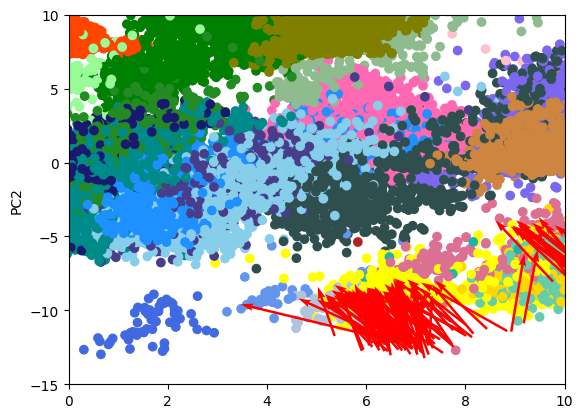

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

'''
functions that prepare the data for plotting

    convert_colorsgray_excepttwo        - function that converts all irrelevany FG colors labels
                                          (not part of reactant and product FG) to gray
    move_rows_to_end                    - moves rows of all the reactand and product FG labelled embeddings
                                          to the end of the data so that they are plotted last 
                                          (on top of everything)

'''

def convert_colorsgray_excepttwo(COLORS, KEEP_COLORS):
    '''
    Converts all colors to gray except for specified ones

        Args:
            COLORS          - the list of all color labels of atoms 
            KEEP_COLORS     - list of hex colors to keep 
        
        Process:
            gray_colors     - a list that will contain all the now grayed out colors 
                              except the ones in KEEP_COLORS
            color           - each hexcolor in COLORS, used to check if this is a color 
                              we should keep
            r,g,b           - converts hexcolor to rgb
            gray_value      - the gray rgb
            gray_hex        - convert gray rgb back to hex

        Returns:
            gray_colors     - a list containing all the grayed out colors
                              except the ones in KEEP_COLORS

    '''
    def rgb_to_hex(r, g, b):
        '''
        converts rgb back to hex
        '''
        return "#{:02x}{:02x}{:02x}".format(r, g, b)

    def hex_to_rgb(hex_color):
        '''
        converts hex to rgb
        '''
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

    def rgb_to_gray(rgb):
        '''
        grays out rgb
        '''
        return int(0.2989 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2])

    gray_colors = []
    for color in COLORS:
        if color in KEEP_COLORS:
            gray_colors.append(color.replace('#','0x'))
        else:
            r, g, b = hex_to_rgb(color)
            gray_value = rgb_to_gray((r, g, b))
            gray_hex = rgb_to_hex(gray_value, gray_value, gray_value)
            gray_colors.append(gray_hex.upper().replace('#','0x'))

    return gray_colors

def move_rows_to_end(DF, COLOR_COL_NAME, KEEP_LABELS):
    '''
    Move specified labels to the end so that they are plotted last

        Args:
            DF                  - the dataframe that needs to be edited
            COLOR_COL_NAME      - the color column name
            KEEP_LABELS         - list of labels (data points) to move to the end
        
        Process:
            'is_keep_color'     - creating a new column of booleans in pandas
                                  dataframes, where its True if the color in this row
                                  is in KEEP_LABELS and false otherwise
            df_keep             - all the colors to move to end, extracted using our new column
            df_rest             - all the colors that will stay

        Returns:
            df_combined         - putting together the two in the order we want them, where the 
                                  relevant target FG's are plotted last, and new temporary column is dropped


    '''

    DF['is_keep_color'] = DF[COLOR_COL_NAME].isin(KEEP_LABELS)
    df_keep = DF[DF['is_keep_color']]
    df_rest = DF[~DF['is_keep_color']]
    df_combined = pd.concat([df_rest, df_keep])
    df_combined = df_combined.drop(columns=['is_keep_color'])
    return df_combined


# Read the CSV file
VEC2VEC_DATA_FILEPATH = SAVE_FILEDIR + 'r2pembs_Ctargetpcavecs.csv'
PCA_SCATTER_FILEPATH = 'data/embs/model1-10000/Cembslayer6pca.csv'


vec2vec_data = pd.read_csv(VEC2VEC_DATA_FILEPATH)
pca_scatter_data = pd.read_csv(PCA_SCATTER_FILEPATH)

# Extract hexadecimal colors from column 136
colors = pca_scatter_data.iloc[:, 136].tolist()


colors_gray = convert_colorsgray_excepttwo(colors, COLORS_TO_KEEP[colors_to_keep])
colors_gray = pd.Series(colors_gray,name='graycolors')

pca_scatter_data2 = pd.concat([pca_scatter_data,colors_gray],axis=1)
pca_scatter_data2 = move_rows_to_end(pca_scatter_data2,'hexcolor', COLORS_TO_KEEP[colors_to_keep])

pca_scatter_data2.to_csv(SAVE_FILEDIR + 'Cembslayer6reordered.csv',index=False)


# Convert hexadecimal colors to RGB
rgb_colors = [(int(color[1:3], 16) / 255, int(color[3:5], 16) / 255, int(color[5:7], 16) / 255) for color in colors]
plt.scatter(pca_scatter_data.iloc[:,0], pca_scatter_data.iloc[:,1], color=rgb_colors)
# Plot each vector
for index, row in vec2vec_data[:].iterrows():
    x_r, y_r, x_p, y_p = row
    plt.quiver(x_r, y_r, x_p, y_p, angles='xy', scale_units='xy', scale=1,color='r',width=0.005)


plt.ylabel('PC1')
plt.ylabel('PC2')
# Set plot limits and aspect ratio
plt.xlim(0,10)
plt.ylim(-15,10)
#plt.gca().set_aspect('equal', adjustable='box')
# Show the plot
plt.show()

In [51]:
import pandas as pd
import numpy as np

# Read data from the first CSV file
df1 = pd.read_csv('data/fgtransform/model1/asym_alkane_H2ox/r2p_la.csv', header=None)
vector1 = df1.iloc[:, 0][0:128].values

# Read data from the second CSV file
df2 = pd.read_csv('data/fgtransform/model1/sym_alkene_H2ox/r2p_la.csv', header=None)
vector2 = df2.iloc[:, 0][0:128].values

# Read data from the second CSV file
df3 = pd.read_csv('data/fgtransform/model1/pr_alcohol_H2ox/r2p_la.csv', header=None)
vector3 = df3.iloc[:, 0][0:128].values

# Read data from the second CSV file
df4 = pd.read_csv('data/fgtransform/model1/dieneophile_ewg/r2p_la.csv', header=None)
vector4 = df4.iloc[:, 0][0:128].values

# Read data from the second CSV file
df5 = pd.read_csv('data/fgtransform/model1/pr_amide_hydro_step1/r2p_la.csv', header=None)
vector5 = df5.iloc[:, 0][0:128].values

# Read data from the second CSV file
df6 = pd.read_csv('data/fgtransform/model1/pr_amide_hydro_step2/r2p_la.csv', header=None)
vector6 = df6.iloc[:, 0][0:128].values


vec_i = vector1
vec_j = vector6

# Calculate the dot product of the two vectors
dot_product = np.dot(vec_i, vec_j)

# Calculate the magnitudes of the two vectors
magnitude1 = np.linalg.norm(vec_i)
magnitude2 = np.linalg.norm(vec_j)

# Calculate the cosine of the angle between the two vectors
cosine_angle = dot_product / (magnitude1 * magnitude2)

# Calculate the angle in radians
angle = np.arccos(cosine_angle)

# Convert the angle to degrees
angle_degrees = np.degrees(angle)

print("Angle between the two vectors:", angle_degrees, "degrees")


Angle between the two vectors: 19.0577078295414 degrees
